# Horizontal scaling of columnar analysis: Dask

(no frills notebook)

<br><br><br><br><br>

There are many ways to spread a computation to many processes or many machines—the most conventional way is to use a batch system.

[Coffea](https://coffeateam.github.io/coffea/) packages up a lot of what I'm about to show in a HEP-oriented framework. The next major version, based on dask-awkward, is [still in pre-release](https://pypi.org/project/coffea/#history) but will be in final release soon.

This notebook will focus on Dask and dask-awkward.

## General introduction to Dask

In [1]:
import dask

Eager Python code:

In [2]:
def increment(i):
    return i + 1

def add(a, b):
    return a + b

a, b = 1, 12
c = increment(a)
d = increment(b)
output = add(c, d)

output

15

Lazy Python code:

In [3]:
@dask.delayed
def increment(i):
    return i + 1

@dask.delayed
def add(a, b):
    return a + b

a, b = 1, 12
c = increment(a)
d = increment(b)
output = add(c, d)

output

Delayed('add-0cb89613-2d88-492e-a381-371f393c3b04')

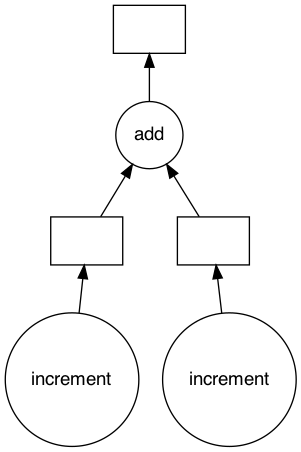

In [4]:
output.visualize()

In [5]:
output.compute()

15

<br><br><br><br><br>

A delayed computation is a set of instructions to run it, which we can send to remote computers to run it remotely.

When we break up a large computation, send it to many computers, and collect the results, we have distributed the computation.